In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
data = pd.read_csv('data/DukeAttendanceV8_HomeOnly_pastDataV2.csv')

print(data)

print(data.dtypes)

                OppName  Year  OppFPI  DukeFPI  FPI_diff  DukeFPI_NetChange  \
0           Florida St.  2001     NaN      NaN       NaN                NaN   
1          Northwestern  2001     NaN      NaN       NaN                NaN   
2          Georgia Tech  2001     NaN      NaN       NaN                NaN   
3           Wake Forest  2001     NaN      NaN       NaN                NaN   
4            Vanderbilt  2001     NaN      NaN       NaN                NaN   
..                  ...   ...     ...      ...       ...                ...   
136        Northwestern  2023     0.8      8.9      -8.1                3.7   
137          Notre Dame  2023    22.1      8.9      13.2                3.7   
138  North Carolina St.  2023     7.3      8.9      -1.6                3.7   
139         Wake Forest  2023    -1.7      8.9     -10.6                3.7   
140          Pittsburgh  2023    -0.5      8.9      -9.4                3.7   

     OppFPI_PrevYear  FPI_Diff_PrevYear  Site  Mont

In [11]:
# Select relevant columns
refined_data = data[['Year', 'OppFPI_PrevYear', 'FPI_Diff_PrevYear', 'Month', 'Date', 'OnSaturday', 
                     'Start_Time', 'After_COVID', 'UNC_Game', 'First_Game', 'First_Home_Game', 
                     'Cutcliffe', 'NC_Opponent', 'OppCityDist', 'AttOver90Pct']]

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')
refined_data = pd.DataFrame(imputer.fit_transform(refined_data), columns=refined_data.columns)

# Define features and target
y = refined_data['AttOver90Pct']
X = refined_data.drop('AttOver90Pct', axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.896551724137931
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        26
         1.0       0.00      0.00      0.00         3

    accuracy                           0.90        29
   macro avg       0.45      0.50      0.47        29
weighted avg       0.80      0.90      0.85        29

% = 89.66


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


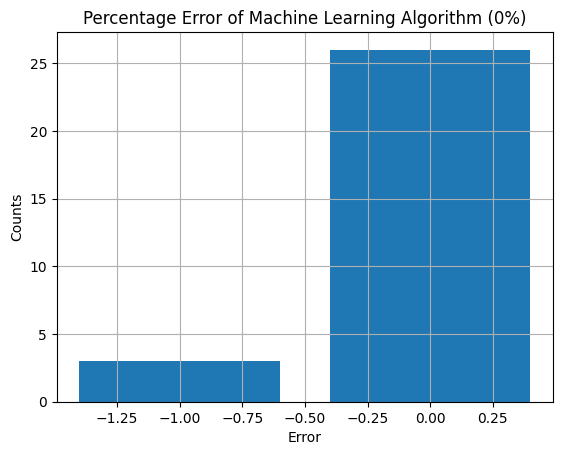


Importance of each feature used in the model:
OppCityDist: 0.23464085272710747
Start_Time: 0.20074660791741258
Date: 0.13081395838929985
Year: 0.0964284620845244
OppFPI_PrevYear: 0.0960844743279165
FPI_Diff_PrevYear: 0.0676897255176213
Cutcliffe: 0.05862575415210664
Month: 0.04020180796999485
UNC_Game: 0.0283536116783323
First_Home_Game: 0.016010104670895635
First_Game: 0.011951639428974719
After_COVID: 0.011620629660262383
NC_Opponent: 0.005919239159878932
OnSaturday: 0.0009131323156726245


Correlation matrix of the dataframe, showing the Pearson correlation
coefficients between each pair of features:
AttOver90Pct         1.000000
Start_Time           0.428678
UNC_Game             0.251914
Cutcliffe            0.235005
NC_Opponent          0.233143
First_Home_Game      0.180449
OppFPI_PrevYear      0.165222
First_Game           0.158952
OppCityDist          0.152980
FPI_Diff_PrevYear    0.127862
OnSaturday           0.120293
Date                 0.088965
Year                 0.08185

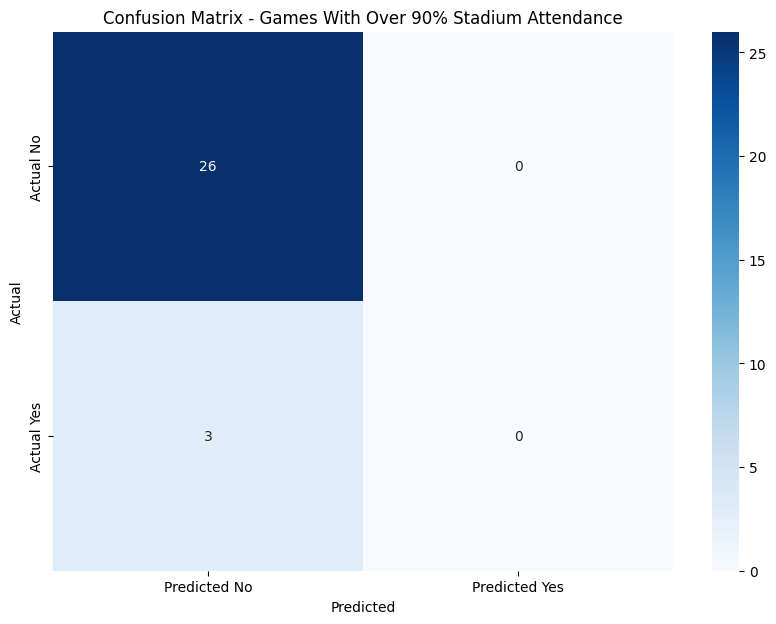

In [12]:
# Create a Random Forest Classifier
model = RandomForestClassifier(max_depth = None, max_features = 10, min_samples_leaf = 2, min_samples_split = 2, n_estimators=500, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

results = y_pred - y_test
unique, counts = np.unique(results, return_counts=True)
print("% = {:.2f}".format(counts[np.where(unique==0)[0][0]]/np.sum(counts) * 100))

fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1, 1, 1)
ax.bar(unique, counts)
ax.set(xlabel='Error', ylabel='Counts',
       title='Percentage Error of Machine Learning Algorithm (0%)')
ax.grid(True)
plt.show()

#%%

print("\nImportance of each feature used in the model:")
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
for idx in sorted_indices:
    print(f"{X.columns[idx]}: {feature_importances[idx]}")

#%%

print("\n\nCorrelation matrix of the dataframe, showing the Pearson correlation\ncoefficients between each pair of features:")
correlation_matrix = refined_data.corr()
target_correlation = correlation_matrix['AttOver90Pct'].abs().sort_values(ascending=False)
print(target_correlation)

#%%

print("\n\nFeatures ranked via RFE:")
from sklearn.feature_selection import RFE
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X_train, y_train)
ranked_features = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), X.columns))
print(ranked_features)


#%%

print("\n\nFeatures ranked via ANOVA F-value:")
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train, y_train)
ranked_features = sorted(zip(map(lambda x: round(x, 4), selector.scores_), X.columns))
print(ranked_features)

#%%

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Games With Over 90% Stadium Attendance')
plt.show()

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 14],
    'max_features': ['sqrt', 'log2', 2, 3, 5, 6, 8, 10, 12, 14, 16]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Use the best parameters to train the final model
best_model = RandomForestClassifier(**best_params, bootstrap = True, random_state=42)
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 9856 candidates, totalling 49280 fits
Best parameters found:  {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Mean Absolute Error: 0.10344827586206896
Mean Squared Error: 0.10344827586206896
R² Score: -0.11538461538461564


In [37]:
print(X_test)
print("\n")
print(y_test)
print("\n")

# Find indices of false negatives
false_negatives = np.where((y_pred == 0) & (y_test == 1))[0]

# Display the rows that are false negatives
print("False Negative Rows:")
for index in false_negatives:
    print(f"Row {index}: Actual = {y_test.iloc[index]}, Predicted = {y_pred[index]}")


       Year  OppFPI_PrevYear  FPI_Diff_PrevYear  Month  Date  OnSaturday  \
68   2011.0         5.300000           9.300000   11.0  19.0         1.0   
108  2017.0         7.400000           5.800000   11.0  18.0         1.0   
31   2006.0         7.700000          21.500000    9.0  30.0         1.0   
51   2009.0         9.200000           9.500000   10.0   3.0         1.0   
95   2015.0         7.200000          -0.500000   11.0  14.0         1.0   
137  2023.0        12.600000           7.300000    9.0  30.0         1.0   
82   2013.0         7.000000           8.700000   11.0  16.0         1.0   
114  2018.0         8.900000           2.300000   11.0  24.0         1.0   
134  2023.0        17.600000          12.300000    9.0   4.0         0.0   
12   2003.0         4.694681           6.821277    9.0   6.0         1.0   
27   2005.0         4.694681           6.821277   10.0  15.0         1.0   
45   2008.0         7.900000          17.400000    9.0  27.0         1.0   
19   2004.0 